In [3]:
!pip install swig
!pip install "gymnasium[box2d]"

!pip install --upgrade gymnasium

!sudo apt-get install libsdl2-dev


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 36.4 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376417 sha256=674486f8ce875da5ce0a66d2cec027b4a07dfb3f9a647ef7dba5299264b22494
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  gir1.2-ibus-1.0 libblkid-dev libblkid1 libdbus-1-dev libdecor-0-dev
  libdrm-dev libegl-dev libegl1-mesa-dev libffi-dev libgbm-dev libgl-dev
  libgles-dev libgles1 libglib2.0-dev libglib2.0-dev-bin libglu1-mesa
  libglu1-mesa-dev libglvnd-core-dev libglvnd-dev lib

In [4]:
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import deque
from skimage.transform import resize


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


# env


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: Depre

Observation Space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Max Observation Value: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
State shape: (8,)


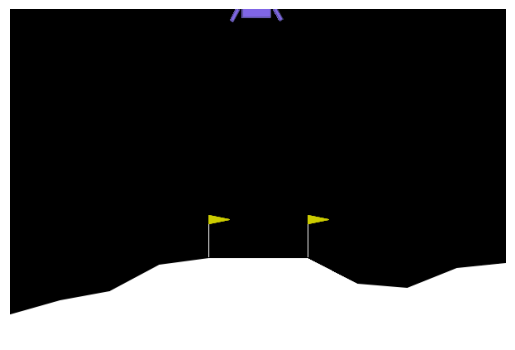

In [5]:
# Buat environment Breakout
# gym.register_envs(ale_py)

# Membuat environment BreakoutDeterministic-v4
env = gym.make("LunarLander-v3", continuous=False, turbulence_power=1.5,render_mode="rgb_array")

# Menampilkan informasi tentang environment
print("Observation Space:", env.observation_space)
print("Max Observation Value:", env.observation_space)
# env=gymnasium.make("BreakoutDeterministic-v4")
obs, info = env.reset()
# obs,_,_,_,_ = env.step(1)

# Tampilkan dimensi state (gambar berwarna)
print(f"State shape: {obs.shape}")

# Render lingkungan untuk melihat tampilan awal
plt.imshow(env.render())
plt.axis('off')  # Opsional: menyembunyikan sumbu
plt.show()

# Tutup environment
env.close()

# preprocecing data img

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


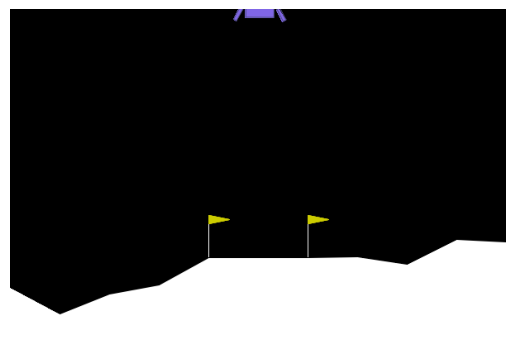

frame: [ 0.0061697   1.4074593   0.62491226 -0.15383181 -0.00714241 -0.14155209
  0.          0.        ]
Stacked state shape: (4, 8)
stacked frames shape: 4
pixel state shape: [[ 0.0061697   1.4074593   0.62491226 -0.15383181 -0.00714241 -0.14155209
   0.          0.        ]
 [ 0.0061697   1.4074593   0.62491226 -0.15383181 -0.00714241 -0.14155209
   0.          0.        ]
 [ 0.0061697   1.4074593   0.62491226 -0.15383181 -0.00714241 -0.14155209
   0.          0.        ]
 [ 0.0061697   1.4074593   0.62491226 -0.15383181 -0.00714241 -0.14155209
   0.          0.        ]]


In [6]:
# Fungsi untuk preprocessing frame
def preprocess_frame(state):
    # Resize frame ke ukuran baru (84x84), tetap RGB
    # state = state/63
    # state= np.expand_dims(state, axis=-1)
    return state

# Fungsi untuk stack frame
def stack_frames(state_stak, new_state, is_new_episode, stack_size=4):
    if is_new_episode:
        # Jika episode baru, reset stack dengan frame awal yang sama
        state_stak = deque([new_state] * stack_size, maxlen=stack_size)
    else:
        # Tambahkan frame baru ke stack
        state_stak.append(new_state)

    # Konversi ke numpy array
    stacked_state = np.stack(state_stak, axis=0)
    return stacked_state, state_stak

# Contoh penggunaan
env = gym.make("LunarLander-v3", continuous=False, turbulence_power=1.5,render_mode="rgb_array")

obs, info = env.reset()

# Initialize deque untuk frame stacking
stack_size = 4
stacked_frames = deque(maxlen=stack_size)

# Preprocess frame awal
frame = preprocess_frame(obs)


# Stack frame
stacked_state, stacked_frames = stack_frames(stacked_frames, frame, is_new_episode=True)

plt.imshow(env.render())
plt.axis('off')
plt.show()

print(f"frame: {frame}")  # Output: (84, 84)
print(f"Stacked state shape: {stacked_state.shape}")  # Output: (84, 84, 4)
print(f"stacked frames shape: {len(stacked_frames)}")  # Output: (84, 84, 4)
print(f"pixel state shape: {stacked_state}")

env.close()


# replay buffer

In [7]:
# tempat menyimpan meory pengalaman
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        # Mengambil batch secara acak dari buffer
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]

        # Mengonversi batch menjadi numpy array
        states = np.array([item[0] for item in batch])
        actions = np.array([item[1] for item in batch])
        rewards = np.array([item[2] for item in batch])
        next_states = np.array([item[3] for item in batch])
        dones = np.array([item[4] for item in batch])

        return (tf.convert_to_tensor(states, dtype=tf.float32),
                tf.convert_to_tensor(actions, dtype=tf.int32),
                tf.convert_to_tensor(rewards, dtype=tf.float32),
                tf.convert_to_tensor(next_states, dtype=tf.float32),
                tf.convert_to_tensor(dones, dtype=tf.float32))

    def size(self):
        return len(self.buffer)


# create model

In [ ]:

def create_model_DQN(input_shape, action_space):
    # Input layer untuk frame-stack
    inputs = Input(shape=input_shape)

    # Permute layer untuk mengubah urutan dimensi menjadi (4,84, 84, 3)
    # x = layers.Permute((4,1, 2, 3))(inputs)  # (4,84, 84, 3) (seq,tingi,lebar,chanel)

    # TimeDistributed Conv2D layers
    x = layers.TimeDistributed(layers.Dense(32, activation='relu'))(inputs)
    x = layers.TimeDistributed(layers.Dense(64, activation='relu'))(x)

    # LSTM layer untuk memproses urutan frame
    x = layers.LSTM(512)(x)

    # Fully connected layers untuk output Q-values
    outputs = layers.Dense(action_space, activation='linear')(x)

    # Membuat model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model




# training


## set env dan model

In [ ]:
env = gym.make("LunarLander-v3", continuous=False, turbulence_power=1.5,render_mode="rgb_array")

action_space = env.action_space.n  # Jumlah aksi dalam Breakout
observation_space = env.observation_space.shape  # Dimensi state (gambar berwarna)
stack_size = 4
input_shape = (stack_size,*observation_space)  # Frame stack dengan RGB
print(f"input shape: {input_shape}")

print(f"action space: {action_space}")

model = create_model_DQN(input_shape, action_space)
target_model = create_model_DQN(input_shape, action_space)
optimazer=tf.keras.optimizers.Adam(learning_rate=0.001)

# Menyalin bobot dari model utama ke target model
target_model.set_weights(model.get_weights())

model.summary()


input shape: (4, 8)
action space: 4


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 4, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 4, 32)               │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 4, 64)               │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 512)                 │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,186,148 (4.52 MB)

 Trainable params: 1,186,148 (4.52 MB)

 Non-trainable params: 0 (0.00 B)

## loss fuction

In [ ]:
@tf.function
def train_step(batch, model, target_model,optimizer, gamma):
    states, actions, rewards, next_states, dones = batch

    with tf.GradientTape() as tape:

        # Prediksi Q-values untuk states dan next_states
        q_values = model(states)
        next_q_values = target_model(next_states)

        # Ambil Q-values yang relevan untuk tindakan yang diambil (menggunakan actions)
        q_values = tf.reduce_sum(q_values * tf.one_hot(actions, model.output_shape[-1]), axis=-1)
        # print(f"q_values shape: {q_values.shape}")

        # Q-targets
        next_q_targets = tf.reduce_max(next_q_values, axis=-1)  # Ambil Q-values maksimum untuk next state
        q_targets = rewards + gamma * next_q_targets * (1 - dones)  # Bellman equation
        # print(f"q_targets shape: {q_targets.shape}")
        # Hitung loss (MSE)
        loss = tf.reduce_mean(tf.keras.losses.MSE(q_targets, q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss


## training fuction

In [ ]:
from tqdm import tqdm

def train_dqn(env, model, target_model, optimizer, replay_buffer, gamma, epsilon, batch_size, update_target_freq, num_episodes):
    episode_rewards = [0]
    episode_loss_mean = [0]
    total_steps = 0
    max_score=-np.inf
    # Initialize the outer progress bar for episodes

    pbar = tqdm(total=num_episodes, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    for episode in range(num_episodes):
        state, _ = env.reset()
        state = preprocess_frame(state)
        stacked_frames = deque(maxlen=stack_size)
        state_stack, stacked_frames = stack_frames(stacked_frames, state, is_new_episode=True,stack_size=stack_size)
        # state_stack = np.expand_dims(state_stack, axis=0)
        episode_reward = 0
        done = False
        pbar.set_description(f"Training loss for step {episode+1}: eps_rewards: {episode_rewards[-1]:.2f}, loss_mean_eps: {episode_loss_mean[-1]:.4f}")
        pbar.update()
        losses=[]
        step=0

        while not done:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()  # Eksplorasi
            else:
                q_values = model.predict(np.expand_dims(state_stack, axis=0),verbose=0)
                action = np.argmax(q_values[0])  # Eksploitasi

            next_state, reward, done, _, info = env.step(action)
            next_state = preprocess_frame(next_state)
            next_state_stack, _ = stack_frames(stacked_frames, next_state, is_new_episode=False)
            # next_state_stack = np.expand_dims(next_state_stack, axis=0) # add dim batch

            # Simpan pengalaman ke replay buffer
            replay_buffer.store(state_stack, action, reward, next_state_stack, done)

            # Perbarui state dan reward
            state_stack = next_state_stack
            episode_reward += reward
            total_steps += 1

            # info updet
            pbar.set_description(f"Training for step {episode+1}: eps_info: {info},  reps_eward: {episode_reward}, loss_mean_eps: {episode_loss_mean[-1]:.4f}")
            pbar.update(0)

            # Pelatihan model jika replay buffer cukup besar
            if replay_buffer.size() > batch_size:
                batch = replay_buffer.sample(batch_size)
                loss = train_step(batch, model, target_model,optimizer, gamma)
                losses.append(loss.numpy())

            # Perbarui target model
            if total_steps % update_target_freq == 0:
                target_model.set_weights(model.get_weights())

            step+=1
            if step==1000:
                break

        if episode>80 and max_score<episode_reward:
          max_score=episode_reward
          model.save('model.h5')

        epsilon = max(0.2, epsilon * 0.995)  # Kurangi epsilon untuk eksplorasi
        episode_loss_mean.append(np.mean(losses))


        episode_rewards.append(episode_reward)

    return episode_rewards




## training proses

Training for step 82: eps_info: {},  reps_eward: -151.57967788200318, loss_mean_eps: 20.1543:  16%|█▋        | 82/500 WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
Training for step 83: eps_info: {},  reps_eward: -131.15880434132157, loss_mean_eps: 20.5324:  17%|█▋        | 83/500 WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
Training for step 84: eps_info: {},  reps_eward: -60.79804810014643, loss_mean_eps: 17.3985:  17%|█▋        | 84/500 WARNING:absl:You are saving your model as an HDF5 file via 

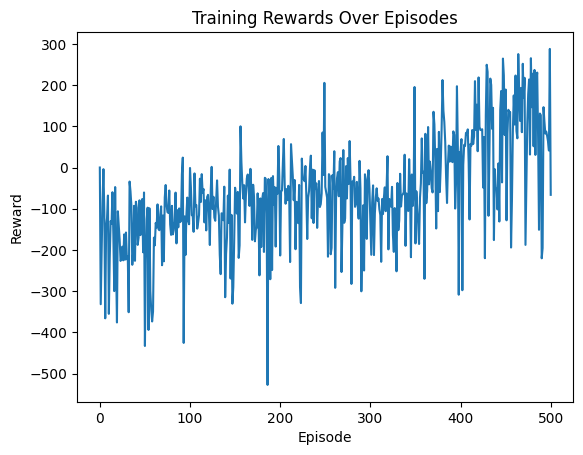

In [11]:
gamma = 0.99
epsilon = 1.0
batch_size = 64
update_target_freq = 5000
num_episodes = 500

replay_buffer = ReplayBuffer(max_size=100000)

episode_rewards = train_dqn(
    env=env,
    model=model,
    target_model=target_model,
    optimizer=optimazer,
    replay_buffer=replay_buffer,
    gamma=gamma,
    epsilon=epsilon,
    batch_size=batch_size,
    update_target_freq=update_target_freq,
    num_episodes=num_episodes
)

# Plot hasil reward
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Rewards Over Episodes')
plt.show()

In [9]:
import glob
import io
import base64
import imageio
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import clear_output, Video,HTML


def show_video_of_model(agent):
    env = gym.make("LunarLander-v3", continuous=False, turbulence_power=1.5,render_mode="rgb_array")
    state, _ = env.reset()
    state = preprocess_frame(state)
    stacked_frames = deque(maxlen=stack_size)
    state_stack, stacked_frames = stack_frames(stacked_frames, state, is_new_episode=True, stack_size=4)
    done = False
    frames = []
    step = 0
    for i in range(10000):
        frame = env.render()
        frames.append(frame)
        q_values = model.predict(np.expand_dims(state_stack, axis=0), verbose=0)
        action = np.argmax(q_values[0])
        next_state, reward, done, _, info = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state_stack, _ = stack_frames(stacked_frames, next_state, is_new_episode=False)
        state_stack = next_state_stack
        clear_output(wait=True)
        print(action)
        print(info)
        if done:
            break
    env.close()
    imageio.mimsave('video.mp4', frames, fps=30)

model= tf.keras.models.load_model('/content/model (1).h5')
model.summary
show_video_of_model(model)


def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()

0
{}
